## **Project**:  Toxic Content Classifier

* Jignesh Madhani
* Pankaj Patil
* Manish Lokhande


### **OBJECTIVES**: 
* Train a model on the Toxic Comment Classification Challenge.
* Save the trained models and vectors and deploy in an application to achieve classification on live data.


## Import relevant libraries and load the data

In [81]:
!pip install nltk

In [82]:
# Import relevant packages
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  # To remove irrelevant words
from nltk.stem.lancaster import LancasterStemmer  # To convert words to base form; aggressive

# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [83]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [84]:
# Download stopwords in english language
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

### Load the training dataset - train.tsv

In [85]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [86]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [87]:
# https://drive.google.com/file/d/1tKTRmd6bve_FZ9yCdOn426fNkV5ZHskQ/view?usp=sharing
downloaded = drive.CreateFile({'id': '1tKTRmd6bve_FZ9yCdOn426fNkV5ZHskQ'}) 
downloaded.GetContentFile('train.tsv')  
data = pd.read_csv('train.tsv')

data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Entries with all 0 under the 6 categories are neutral and considered as non-toxic.

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


There are no missing values in the dataset.

## Looking at the comments in the dataset.

In [89]:
data['comment_text'][0]

"Explanation\r\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [90]:
data['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [91]:
data['comment_text'][3]

'"\r\nMore\r\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\r\n\r\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

The comments are dirty with '\n' values, symbols, numbers that will not be useful for analysis. We will be removing these and clean the data.

## Exploratory Data Analysis

In [92]:
# Check percentage of comments that are toxic compared to normal comments
data.toxic.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

It seems that only 10% of the comments fall in the toxic category.

In [93]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [94]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=data.iloc[:,2:].sum()

In [95]:
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


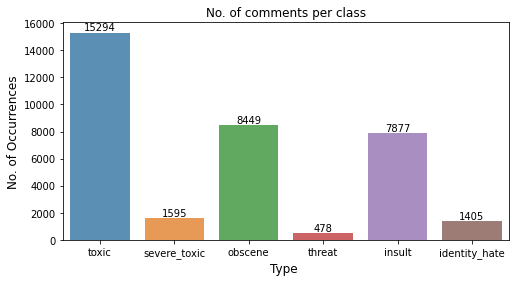

In [96]:
# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category. alpha = 0.8 to make the bars more translucent
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels for each bar
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [97]:
num_rows = len(data)
print(num_rows)

159571


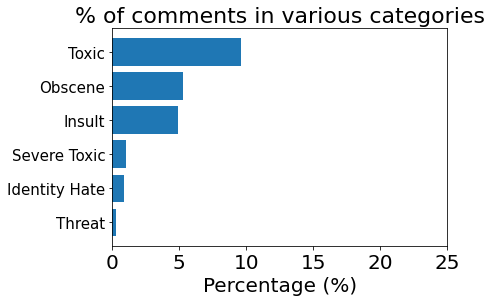

In [98]:
# Create a bar graph 
sum_tox = data['toxic'].sum() / num_rows * 100
sum_sev = data['severe_toxic'].sum() / num_rows * 100
sum_obs = data['obscene'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_ins = data['insult'].sum() / num_rows * 100
sum_ide = data['identity_hate'].sum() / num_rows * 100

# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()


## Preprocess the text

In [99]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation\r why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

## Dividing the dataset into 6 sections based on classes in the dataset.

In [100]:
data_tox = data.loc[:,['id','comment_text','toxic']]

In [101]:
data_tox['comment_text'][0]

'explanation\r why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [102]:
data_tox['comment_text'][1]

'd aww  he matches this background colour i m seemingly stuck with  thanks    talk       january       utc '

In [103]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]

In [104]:
data_obs = data.loc[:,['id','comment_text','obscene']]

In [105]:
data_thr = data.loc[:,['id','comment_text','threat']]

In [106]:
data_ins = data.loc[:,['id','comment_text','insult']]

In [107]:
data_ide = data.loc[:,['id','comment_text','identity_hate']]

## Creating WordCloud
### Shows the words which occur most frequently for each category. 
#### Warning: Profanity ahead.

In [108]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [109]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

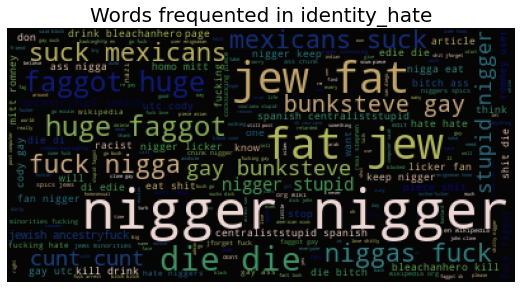

In [110]:
wordcloud(data_ide,'identity_hate')

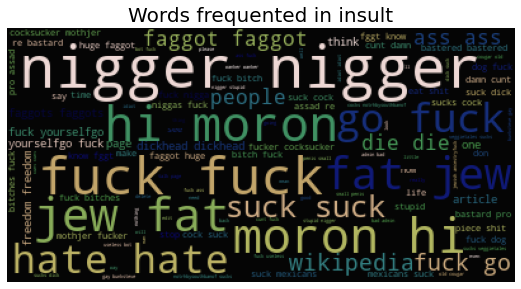

In [111]:
wordcloud(data_ins, 'insult')

#### Earlier, we saw that comments that are toxic (and other forms of toxicity) make up less than 10% of the comments in the data. This leads to the issue of class imbalance.

#### We deal with class imbalance by taking a subset of the data where the proportion of the toxic comments are at least 20% (ideally 50%) in relation to non-toxic comments.

#### For a start, we can take 5000 rows of comments that are toxic and concatenate them row-wise with those that are not toxic so that we have a balanced dataset.

In [112]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation\r why the edits made under my user...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,\r more\r i can t make any real suggestions o...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [113]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [114]:
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

In [115]:
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(10000, 3)

### Not all categories have 5000 rows. So we should count them first and balance them accordingly.

In [116]:
data_sev[data_sev['severe_toxic'] == 1].count()


id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [117]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3190, 3)

We only had 1,595 comments that are severely toxic. We combine it together with another 1,595 comments that are not toxic to form a new dataset that is balanced. We repeat this for all other categories.

In [118]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [119]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(10000, 3)

In [120]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

The number of threat comments of 478 is too miniscule when addded with another 478 clean comments for a proper analysis. We decided that the clean comments will comprise 80% at the most of the dataset, as shown below.

In [121]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [122]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [123]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(10000, 3)

In [124]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [125]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(7025, 3)

Reminder: Number of comments that fall into the following categories:

- Toxic (14,000+) 
- Severe Toxic (1595)
- Obscene (8449)
- Threat (478)
- Insult (7877)
- Identity Hate (1405)

#### df_****_done refers to the dataframes of each class that has been balanced (at least 20/80 proportion)

|                      | DF name       | No. of pts (1) | No. of pts (0) | Total data pts |
|----------------------|---------------|----------------|----------------|----------------|
| Toxic                | data_tox_done | 5000           | 5000           | 10000          |
| Severe Toxic         | data_sev_done | 1595           | 1595           | 3190           |
| Obscene (8449)       | data_obs_done | 5000           | 5000           | 10000          |
| Threat (478)         | data_thr_done | 478            | 1912           | 2390           |
| Insult (7877)        | data_ins_done | 5000           | 5000           | 10000          |
| Identity Hate (1405) | data_ide_done | 1405           | 5620           | 7025           |

### Import relevant packages for modelling

In [126]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to spliting data and evaluating model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


### Create simple function that takes in a dataset and allows user to choose dataset, toxicity label, vectorizer and number of ngrams

In [127]:
'''
df_done: data_tox_done, data_sev_done, ...
label: toxic, severe_toxic, ...
vectorizer values: CountVectorizer, TfidfVectorizer
gram_range values: (1,1) for unigram, (2,2) for bigram
'''
def cv_tf_train_test(df_done,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1


### Let's create a TF-IDF vectorizer object for each category and calculate the F1 scores across all models

In [128]:
'''
def cv_tf_train_test(df_done,label,vectorizer,ngram)
vectorizer values: CountVectorizer, TfidfVectorizer
ngram_range values: (1,1) for unigram, (2,2) for bigram
'''

import time

t0 = time.time()

df_tox_cv = cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

# Various permutations of the dataset, category, vectorizer and n-gram

# cv_tf_train_test(data_tox_done, 'toxic', CountVectorizer, (1,1))
# cv_tf_train_test(data_sev_done, 'severe_toxic', CountVectorizer, (1,1))
# cv_tf_train_test(data_obs_done, 'obscene', CountVectorizer, (1,1))
# cv_tf_train_test(data_thr_done, 'threat', CountVectorizer, (1,1))
# cv_tf_train_test(data_ins_done, 'insult', CountVectorizer, (1,1))
# cv_tf_train_test(data_ide_done, 'identity_hate', CountVectorizer, (1,1))

# cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))


lr done
bnb done
mnb done
rdf done
Time taken: 10.519789695739746 seconds


,F1 Score(toxic)
Log Regression,0.861234
KNN,0.185120
BernoulliNB,0.776521
MultinomialNB,0.874958
SVM,0.876133
Random Forest,0.838055


In [129]:

t0 = time.time()

df_sev_cv = cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

lr done
bnb done
mnb done
rdf done
Time taken: 1.790165901184082 seconds


,F1 Score(severe_toxic)
Log Regression,0.927879
KNN,0.857416
BernoulliNB,0.803707
MultinomialNB,0.936170
SVM,0.926004
Random Forest,0.934874


In [130]:

t0 = time.time()

df_obs_cv = cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

lr done
bnb done
mnb done
rdf done
Time taken: 9.109896659851074 seconds


,F1 Score(obscene)
Log Regression,0.908655
KNN,0.519056
BernoulliNB,0.787830
MultinomialNB,0.901463
SVM,0.921378
Random Forest,0.909091


In [131]:

t0 = time.time()

df_thr_cv = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

lr done
bnb done
mnb done
rdf done
Time taken: 1.2005681991577148 seconds


,F1 Score(threat)
Log Regression,0.628821
KNN,0.720000
BernoulliNB,0.311828
MultinomialNB,0.504762
SVM,0.786765
Random Forest,0.795539


In [132]:

t0 = time.time()

df_ins_cv = cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv

lr done
bnb done
mnb done
rdf done
Time taken: 9.35407829284668 seconds


,F1 Score(insult)
Log Regression,0.896599
KNN,0.257992
BernoulliNB,0.783762
MultinomialNB,0.897411
SVM,0.902619
Random Forest,0.883993


In [133]:

t0 = time.time()

df_ide_cv = cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

lr done
bnb done
mnb done
rdf done
Time taken: 5.1058189868927 seconds


,F1 Score(identity_hate)
Log Regression,0.699029
KNN,0.230159
BernoulliNB,0.549206
MultinomialNB,0.485857
SVM,0.797516
Random Forest,0.768448


In [134]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all


,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
Log Regression,0.861234,0.927879,0.908655,0.896599,0.628821,0.699029
KNN,0.185120,0.857416,0.519056,0.257992,0.720000,0.230159
BernoulliNB,0.776521,0.803707,0.787830,0.783762,0.311828,0.549206
MultinomialNB,0.874958,0.936170,0.901463,0.897411,0.504762,0.485857
SVM,0.876133,0.926004,0.921378,0.902619,0.786765,0.797516
Random Forest,0.838055,0.934874,0.909091,0.883993,0.795539,0.768448


### Transpose the combined F1 dataframe to make it suitable for presentation on a graph

In [135]:
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.861234,0.185120,0.776521,0.874958,0.876133,0.838055
F1 Score(severe_toxic),0.927879,0.857416,0.803707,0.936170,0.926004,0.934874
F1 Score(obscene),0.908655,0.519056,0.787830,0.901463,0.921378,0.909091
F1 Score(insult),0.896599,0.257992,0.783762,0.897411,0.902619,0.883993
F1 Score(threat),0.628821,0.720000,0.311828,0.504762,0.786765,0.795539
F1 Score(identity_hate),0.699029,0.230159,0.549206,0.485857,0.797516,0.768448


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

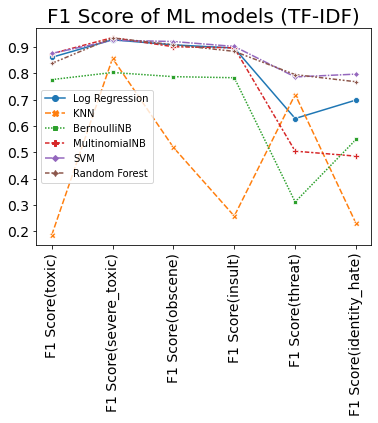

In [136]:
sns.lineplot(data=f1_all_trp, markers=True) # size=[10,10],
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

# Repeat this for CountVectorizer as well

LinearSVC and Random Forest models perform best (purple and brown lines seem to be the highest).

### Test if our code actually works. Probability of the comment falling in various categories should be output.

In [137]:
data_tox_done.head()

,id,comment_text,toxic
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
12,0005c987bdfc9d4b,hey what is it \r talk \r what is it ...,1
16,0007e25b2121310b,bye \r \r don t look come or think of commin...,1
42,001810bf8c45bf5f,you are gay or antisemmitian \r \r archangel ...,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1


In [138]:
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)



array([0, 1, 1, ..., 1, 1, 1])

In [139]:
# Sample Prediction
comment1 = ['You piece of shit']
comment2 = ['This apple is very tasty']

comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]

array([1.])

In [140]:
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]

array([0.16036935])

Random forest has assigned a probability of 1 that comment 1 ('you piece of shit') is toxic. Comment 2 has only a low toxicity probability of 0.16.

## Pickling trained RandomForest models for all categories. 

#### We choose Random Forest instead of LinearSVC although the latter performs well, as RDF has predict_proba function and LinearSVC does not. We need to output a probability score for each comment, remember?

In [141]:
import pickle

### We have to pickle not only the TF-IDF vectorizer object, but also the RDF model trained on the related vectorizer.

In [142]:
'''
NOTE: This step has already been done for you. The pickled files are included in the github. Just for further reference.
You do NOT have to run this cell.
'''

def pickle_model(df, label):
    
    X = df.comment_text
    y = df[label]

    # Initiate a Tfidf vectorizer
    tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    # Convert the X data into a document term matrix dataframe
    X_vect = tfv.fit_transform(X)  
    
    # saves the column labels (ie. the vocabulary)
    # wb means Writing to the file in Binary mode, written in byte objects
    with open(r"{}.pkl".format(label + '_vect'), "wb") as f:   
        pickle.dump(tfv, f)   
        
    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_vect, y)

    # Create a new pickle file based on random forest
    with open(r"{}.pkl".format(label + '_model'), "wb") as f:  
        pickle.dump(randomforest, f)
        

### Create a loop to create pickle files all at one shot

In [143]:
'''
OPTIONAL STEP. Pickled file already available on Github.
'''

datalist = [data_tox_done, data_sev_done, data_obs_done, data_ins_done, data_thr_done, data_ide_done]
label = ['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']

for i,j in zip(datalist,label):
    pickle_model(i, j)
    
